<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone -b magda https://github.com/mgswiss15/deepul.git 
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul
else:
    %load_ext autoreload
    %autoreload 2
    import sys
    import pathlib
    cwd = pathlib.Path().absolute()
    sys.path.append(str(cwd.parents[0]))
    sys.path.append(str(cwd.parents[1]))
    print(sys.path)

['/home/magda/Github/deepul/homeworks/hw2', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul/homeworks', '/home/magda/Github/deepul']


In [2]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


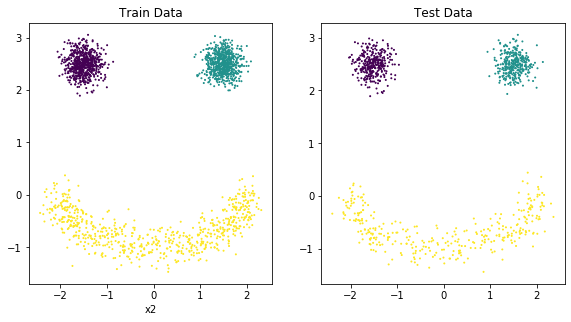

Dataset 2


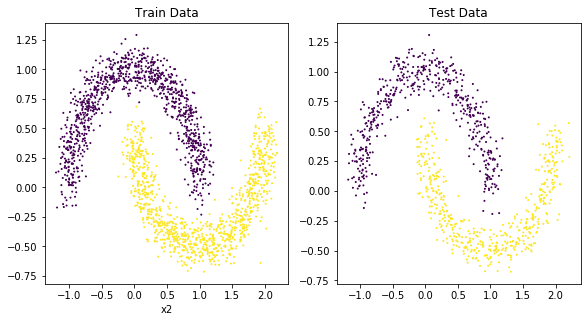

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
from deepul.exp_utils2 import *
from torch.distributions import Normal
from torch.autograd import grad

class Flow1(nn.Module):
    def __init__(self, n_comp):
        super(Flow1, self).__init__()
        self.n_comp = n_comp
        self.mus = nn.Parameter(torch.linspace(-2., 2., steps=self.n_comp))
        self.sigmas = nn.Parameter(torch.ones(self.n_comp))
        self.weight_logits = nn.Parameter(torch.ones(self.n_comp))
        self.components = Normal(self.mus, self.sigmas)
       
    def forward(self,x):
        weights = F.softmax(self.weight_logits, dim=0)
        cdf = self.components.cdf(x)
        z = (weights * cdf).sum(1, keepdim=True)
        pdf = self.components.log_prob(x).exp()
        jacobian = (weights * pdf).sum(1, keepdim=True) # derivative of cdf is pdf
        return z, jacobian
    

class Flow2(nn.Module):
    def __init__(self):
        super(Flow2, self).__init__()
        
    def forward(self, x, mus, logsigmas, weight_logits):
        sigmas = logsigmas.exp()
        weights = F.softmax(weight_logits, dim=1) # careful about dim here (different from flow1)
        cdf = Normal(mus, sigmas).cdf(x)
        z = (weights * cdf).sum(1, keepdim=True)
        pdf = Normal(mus, sigmas).log_prob(x).exp()
        jacobian = (weights * pdf).sum(1, keepdim=True)
        return z, jacobian
    

class Conditioner(nn.Module):
    def __init__(self, n_comp, n_hidden, n_layers):
        super(Conditioner, self).__init__()
        self.n_comp = n_comp
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        layers = []
        in_feat, out_feat = 1, self.n_hidden
        for _ in range(self.n_layers):
            layers.append(nn.Linear(in_feat, out_feat, bias=True))
            in_feat = out_feat
            layers.append(nn.ReLU())
        self.sequential = nn.Sequential(*layers)
        self.l_mus = nn.Linear(in_feat, self.n_comp, bias=True)
        self.l_logsigmas = nn.Linear(in_feat, self.n_comp, bias=True)
        self.l_weight_logits = nn.Linear(in_feat, self.n_comp, bias=True)
    
    def forward(self, x):
        out = self.sequential(x)
        mus = self.l_mus(out)
        logsigmas = self.l_logsigmas(out)
        weight_logits = self.l_weight_logits(out)
        return mus, logsigmas, weight_logits   

    
class AutoregressiveFlow(nn.Module):
    def __init__(self, n_comp1=5, n_comp2=5, n_hidden=64, n_layers=3):
        super(AutoregressiveFlow, self).__init__()
        self.n_comp1 = n_comp1
        self.n_comp2 = n_comp2
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.flow1 = Flow1(self.n_comp1)
        self.conditioner = Conditioner(self.n_comp2, self.n_hidden, self.n_layers)
        self.flow2 = Flow2()
        
    def forward(self, x):
        z1, jacobian1 = self.flow1(x[:,0][:, None])
        mus, logsigmas, weight_logits = self.conditioner(x[:,0][:, None])
        z2, jacobian2 = self.flow2(x[:,1][:, None], mus, logsigmas, weight_logits)
        return torch.cat((z1, z2), dim=1), torch.cat((jacobian1, jacobian2), dim=1)
    
    def log_prob_x_from_z(self, jacobians):
        # uniform.log_prob = 0 for U(0,1) so can be dropped from formula
        log_prob = jacobians.abs().log().sum(dim=1)
        return log_prob
    
    def loss_function(self, z, jacobians):
        loss = -self.log_prob_x_from_z(jacobians).mean()
        return loss
    
    def eval_log_prob(self, x):
        self.eval()
        with torch.no_grad():
            zs, jacobians = self(x)
            log_prob = self.log_prob_x_from_z(jacobians)
        return log_prob

This gives examples of backward()
https://stackoverflow.com/questions/43451125/pytorch-what-are-the-gradient-arguments/47026836

and this probably has it
https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa

In [9]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
    """

    """ YOUR CODE HERE """
    # create data loaders
    DEVICE = torch.device('cuda')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=128)
    model = AutoregressiveFlow(n_comp1=10, n_comp2=10, n_hidden=64, n_layers=3).to(DEVICE)
    optim_algo = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        model, optim_algo, learn_rate=5e-3, device=DEVICE, epochs=100)
    nll_train = np.array(nll_train) / 2
    nll_test = np.array(nll_test) / 2

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.tensor(np.stack([x, y], axis=2).reshape(-1, 2), device=DEVICE, requires_grad=True, dtype=torch.float)
    densities = np.exp(model.eval_log_prob(mesh_xs).detach().cpu().numpy())

    # latents
    train_tensor = torch.tensor(train_data, device=DEVICE, requires_grad=True, dtype=torch.float)
    zs, jacobians = model(train_tensor)
    latents = zs.detach().cpu()
    latents = latents.numpy()
    
    plt.figure()
    plt.hist(latents[:,0], bins=100)
    plt.title('z0')
    plt.show()
    plt.figure()
    plt.hist(latents[:,1], bins=100)
    plt.title('z1')
    plt.show()

    return nll_train, nll_test, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Epoch 0 loss train: 3.562556505203247, test: 3.523637056350708
Epoch 10 loss train: 1.5464361906051636, test: 1.464139699935913
Epoch 20 loss train: 1.2510671615600586, test: 1.3591912984848022
Epoch 30 loss train: 1.57688570022583, test: 1.3915585279464722
Epoch 40 loss train: 1.3552743196487427, test: 1.3810982704162598
Epoch 50 loss train: 1.501284122467041, test: 1.3378857374191284
Epoch 60 loss train: 1.3054839372634888, test: 1.3434382677078247
Epoch 70 loss train: 1.513249397277832, test: 1.3215426206588745
Epoch 80 loss train: 1.2590653896331787, test: 1.3354190587997437
Epoch 90 loss train: 1.248534917831421, test: 1.3825424909591675


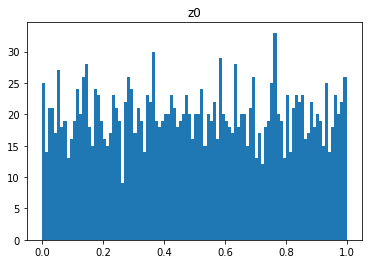

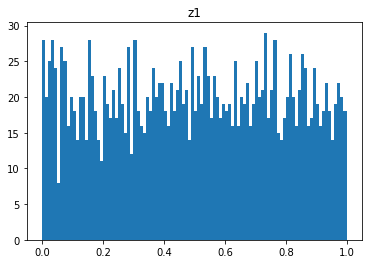

Final Test Loss: 0.6558


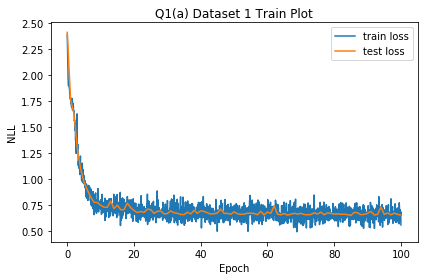

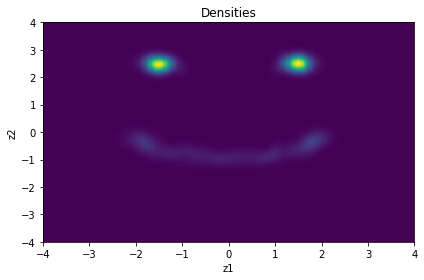

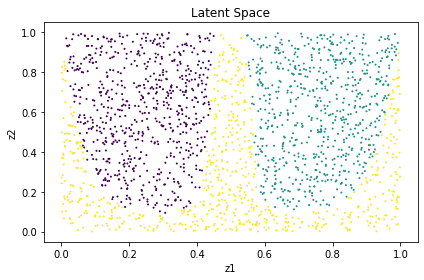

In [10]:
q1_save_results(1, 'a', q1_a)

Epoch 0 loss train: 2.143444061279297, test: 2.1090710163116455
Epoch 10 loss train: 1.085557460784912, test: 1.1712807416915894
Epoch 20 loss train: 1.0918818712234497, test: 1.1280426979064941
Epoch 30 loss train: 1.105019211769104, test: 1.0340473651885986
Epoch 40 loss train: 1.020937442779541, test: 1.0330023765563965
Epoch 50 loss train: 1.0834985971450806, test: 1.0523158311843872
Epoch 60 loss train: 0.9821684956550598, test: 1.0468981266021729
Epoch 70 loss train: 0.9855330586433411, test: 1.040790319442749
Epoch 80 loss train: 1.1158618927001953, test: 1.0419174432754517
Epoch 90 loss train: 0.9476470947265625, test: 1.0288296937942505


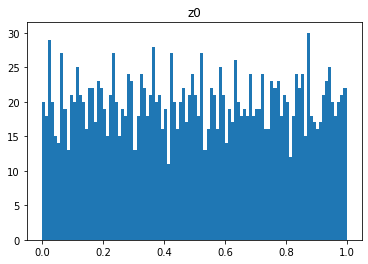

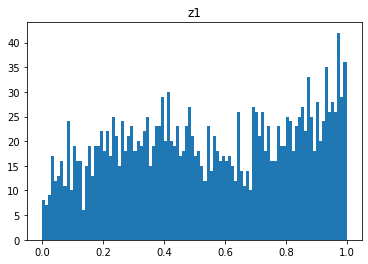

Final Test Loss: 0.5426


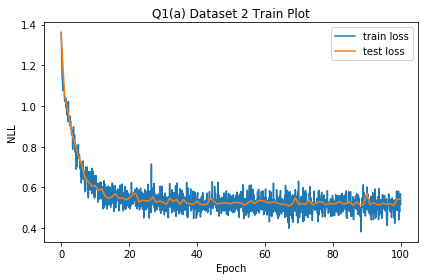

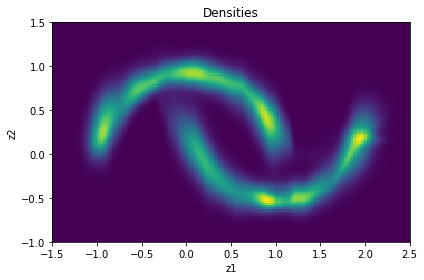

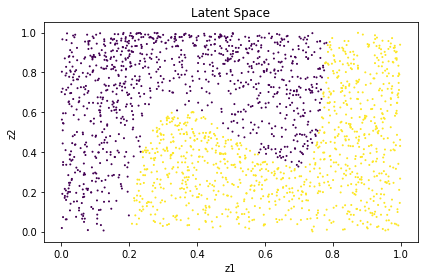

In [11]:
q1_save_results(2, 'a', q1_a)